In [ ]:
!pip install clearml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.6 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0


In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=73RL7WEMIA18G2AELNK0
%env CLEARML_API_SECRET_KEY=kwCw4AJNZZvRiqU35OC5GI3G3YrAZvk4hk63lKbMACHhxMbHtq

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=73RL7WEMIA18G2AELNK0
env: CLEARML_API_SECRET_KEY=kwCw4AJNZZvRiqU35OC5GI3G3YrAZvk4hk63lKbMACHhxMbHtq


### **Loading all necessary libraries**

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from clearml import Dataset, Task, OutputModel

### **Dataset preparation**

In [ ]:
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

def load_and_preprocess_image(image_path):
    """Load an image and preprocess it."""
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image /= 255.0
    return image



In [ ]:
import argparse
import os

import numpy as np
from clearml import Dataset, Task


def save_preprocessed_data(data, labels, data_filename, labels_filename):
    import argparse
    import os

    import numpy as np
    from clearml import Dataset

    np.save(data_filename, data)
    np.save(labels_filename, labels)


In [ ]:
def preprocess_and_upload_data(
    raw_dataset_name, project_name, processed_dataset_name
):
    import argparse
    import os

    import numpy as np
    from clearml import Dataset, Task

    task = Task.init(
        project_name=project_name,
        task_name="Dataset Preprocessing",
        task_type=Task.TaskTypes.data_processing,
    )
    raw_dataset = Dataset.get(dataset_project=project_name, dataset_name=raw_dataset_name)
    raw_data_path = raw_dataset.get_local_copy()
    data = []
    labels = []

    for folder in os.listdir(raw_data_path):
        if folder.startswith("pins_"):
            folder_path = os.path.join(raw_data_path, folder)
            label = folder.replace('pins_', '').replace('_', ' ').replace('2', '')  # Adjusted for naming convention
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                try:
                    image = load_and_preprocess_image(image_path)
                    data.append(image)
                    labels.append(label)
                except Exception as e:
                    print(f"Failed to process {image_path}: {e}")

    # This conditional ensures there's at least one image loaded before attempting to stack
    if data:
        data = np.stack(data)  # Use stack instead of vstack for a list of 3D arrays
        labels = np.array(labels)
    else:
        raise ValueError("No images loaded. Check your dataset path and contents.")

    print(f"Loaded {len(data)} images.")

    # Save the preprocessed arrays to files
    save_preprocessed_data(
        data,
        labels,
        "data_preprocessed.npy",
        "labels_preprocessed.npy",
    )

    # Upload the preprocessed arrays to ClearML

    # Create a new ClearML dataset for the preprocessed data
    processed_dataset = Dataset.create(
        dataset_name=processed_dataset_name,
        dataset_project=project_name,
        parent_datasets=[raw_dataset.id],
    )

    # Add the saved numpy files to the dataset
    processed_dataset.add_files("data_preprocessed.npy")
    processed_dataset.add_files("labels_preprocessed.npy")

    # Upload the dataset to ClearML
    processed_dataset.upload()
    processed_dataset.finalize()

    # Clean up: Remove the numpy files after upload
    os.remove("data_preprocessed.npy")
    os.remove("labels_preprocessed.npy")

    print(f"Preprocessed dataset uploaded with ID: {processed_dataset.id}")
    task.close()

In [ ]:
preprocess_and_upload_data("raw_data", "AttendanceAI", "processed_data")

MissingConfigError: It seems ClearML is not configured on this machine!
To get started with ClearML, setup your own 'clearml-server' or create a free account at https://app.clear.ml
Setup instructions can be found here: https://clear.ml/docs

### **Encoding the images**

In [ ]:
task = Task.init(
        project_name="AttendanceAI",
        task_name="Model Training",
        task_type=Task.TaskTypes.training,
        auto_connect_frameworks="keras",
    )



ClearML Task: created new task id=923cf2f23fd949cf8fc481749d15079c
ClearML results page: https://app.clear.ml/projects/7c535a5376bf478fa3de8e5129f566ed/experiments/923cf2f23fd949cf8fc481749d15079c/output/log


In [ ]:
# Access dataset
dataset = Dataset.get(dataset_project="AttendanceAI", dataset_name="processed_data")
dataset_path = dataset.get_local_copy()

███████████████████████████████ 100% | 64.28/64.28 MB [00:01<00:00, 50.43MB/s]: 


In [ ]:
data = np.load(f"{dataset_path}/data_preprocessed.npy")
labels = np.load(f"{dataset_path}/labels_preprocessed.npy")

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
labels = to_categorical(integer_encoded)

In [ ]:
# Ensure labels are encoded if they're not already in a numerical format
# For categorical_crossentropy, your labels should be one-hot encoded

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)


### **Creating a model for prediction**

In [ ]:
baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dense(len(np.unique(integer_encoded)), activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


### **Compiling and training the model**

In [ ]:
from tensorflow.keras.callbacks import Callback, LambdaCallback
# Inside your training function, after initializing your task:
logger = task.get_logger()

# Manual logging within model.fit() callback
lambda_clbk = LambdaCallback(
        on_epoch_end=lambda epoch, logs: [
            logger.report_scalar(
                "loss", "train", iteration=epoch, value=logs["loss"]
            ),
            logger.report_scalar(
                "accuracy", "train", iteration=epoch, value=logs["accuracy"]
            ),
            logger.report_scalar(
                "val_loss", "validation", iteration=epoch, value=logs["val_loss"]
            ),
            logger.report_scalar(
                "val_accuracy",
                "validation",
                iteration=epoch,
                value=logs["val_accuracy"],
            ),
        ]
    )

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import math
from clearml import Dataset, OutputModel, Task

# Define a simple decay function to decrease the learning rate over epochs
def lr_decay(epoch):
    initial_lr = 1e-4  # Initial learning rate
    drop = 0.5  # Reduce the learning rate by half
    epochs_drop = 10.0  # Reduce the learning rate every 10 epochs
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

# Learning Rate Scheduler callback
lr_scheduler = LearningRateScheduler(lr_decay)

# Compile the model using the Adam optimizer without the decay parameter
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

# Train the model, including the lr_scheduler in the callbacks
H = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=[lr_scheduler, lambda_clbk])

# Save and upload the model to ClearML
model_file_name = "model.h5"
model.save(model_file_name)
output_model = OutputModel(task=task)
output_model.update_weights(
    model_file_name, upload_uri="https://files.clear.ml"
)  # Upload the model weights to ClearML
output_model.publish()  # Make sure the model is accessible
task.upload_artifact("trained_model", artifact_object=model_file_name)

Epoch 1/20
15/15 [==============================] - 19s 635ms/step - loss: 0.8079 - accuracy: 0.6733 - val_loss: 0.4010 - val_accuracy: 0.8609 - lr: 1.0000e-04
Epoch 2/20
15/15 [==============================] - 3s 170ms/step - loss: 0.1786 - accuracy: 0.9622 - val_loss: 0.2773 - val_accuracy: 0.8940 - lr: 1.0000e-04
Epoch 3/20
15/15 [==============================] - 3s 173ms/step - loss: 0.0798 - accuracy: 0.9844 - val_loss: 0.2220 - val_accuracy: 0.9404 - lr: 1.0000e-04
Epoch 4/20
15/15 [==============================] - 3s 170ms/step - loss: 0.0344 - accuracy: 0.9978 - val_loss: 0.1749 - val_accuracy: 0.9338 - lr: 1.0000e-04
Epoch 5/20
15/15 [==============================] - 3s 171ms/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.1509 - val_accuracy: 0.9470 - lr: 1.0000e-04
Epoch 6/20
15/15 [==============================] - 3s 172ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.1409 - val_accuracy: 0.9536 - lr: 1.0000e-04
Epoch 7/20
15/15 [===========================

/usr/local/lib/python3.10/dist-packages/clearml/binding/frameworks/tensorflow_bind.py:1918: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



True

### **Checking the accuracy**

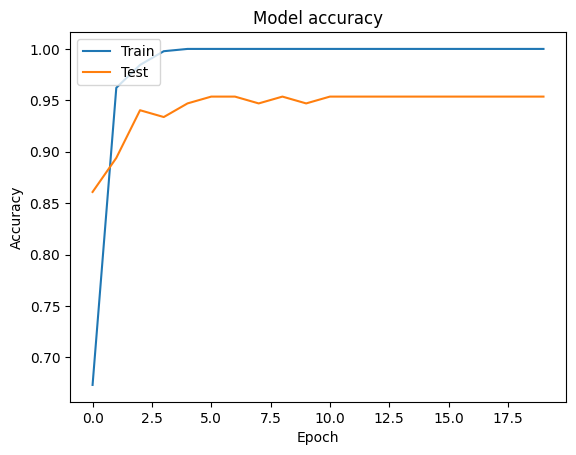

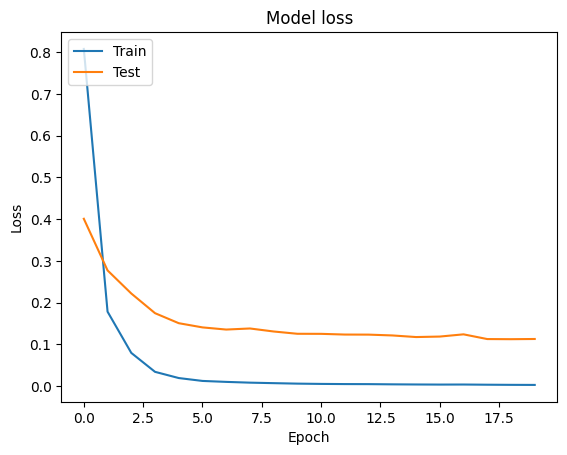

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
logger.report_matplotlib_figure(plt, "accu", "accu")
plt.show()


# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

logger.report_matplotlib_figure(plt, "accu", "accu")
plt.show()

In [ ]:
Task.close(task)

In [ ]:
from keras.preprocessing import image
import numpy as np

# Function to preprocess new images
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.0  # Normalize the image
    return img_tensor

# Load and preprocess the image
new_image_path = '/content/Test.jpeg'
new_image = preprocess_image(new_image_path)

# Make a prediction
predictions = model.predict(new_image)

# Assuming you have more than two classes and are using softmax activation in the last layer
predicted_class = np.argmax(predictions, axis=1)

# If you have the class labels stored (e.g., from a label encoder or manually specified), you can retrieve the label
predicted_label = label_encoder.inverse_transform(predicted_class)
print("Predicted label:", predicted_label)


FileNotFoundError: [Errno 2] No such file or directory: '/content/Test.jpeg'

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from PIL import Image
import io

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# After defining the function, you can use it to capture a photo
image_path = take_photo() # Captures a photo.


In [ ]:
from keras.preprocessing import image

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.0  # Normalize the image
    return img_tensor

# Assuming 'image_path' is the path to the captured image
img_tensor = preprocess_image(image_path)


In [ ]:
predictions = model.predict(img_tensor)
predicted_class = np.argmax(predictions, axis=1)
predicted_label = label_encoder.inverse_transform(predicted_class)
print("Predicted label:", predicted_label)


In [ ]:
task.close()